<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

test

In [25]:
p = build_policy(nn.HybridSequential(),2)
p.initialize(init=init.Xavier())
x = nd.random.normal(shape=(1,4))
p(x)


[[ 0.07166567 -0.27552003]]
<NDArray 1x2 @cpu(0)>

# main loop

In [0]:
#!sudo pip install box2d-py

0 33.0
20 12.0
40 50.0
60 22.0
80 11.0
100 102.0
120 66.0
140 101.0
160 54.0
180 106.0
200 47.0
220 50.0
240 73.0
260 200.0
280 200.0
300 200.0
320 200.0
340 200.0
360 200.0
380 200.0
400 67.0
420 137.0
440 165.0
460 148.0
480 200.0
500 200.0
520 200.0
540 200.0
560 200.0
580 200.0
600 200.0
620 200.0
640 200.0
660 200.0
680 200.0
700 169.0
720 142.0
740 134.0
760 163.0
780 200.0
800 199.0
820 162.0
840 200.0
860 191.0
880 200.0
900 111.0
920 143.0
940 116.0
960 200.0
980 200.0


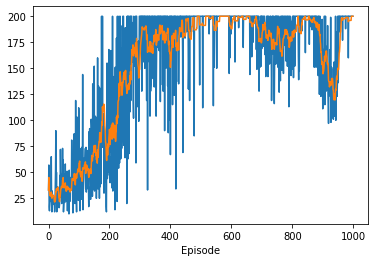

In [27]:
env = gym.make('CartPole-v0')

policy_net = build_policy(nn.HybridSequential(),env.action_space.n)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())

trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':0.001})

max_episode_num = 1000
max_steps = 10000

numsteps = []
avg_numsteps = []

all_rewards = []
avg_all_rewards = []

for episode in range(max_episode_num):
  state = env.reset()
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      state, reward, done, _ = env.step(action.asnumpy()[0])
      log_probs.append(log_prob)
      rewards.append(reward)
      if done:
        break
    
    # logging
    numsteps.append(t)
    avg_numsteps.append(np.mean(numsteps[-10:]))
    
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(t)
  
  # print info
  if episode % 20 == 0:
    print(episode,all_rewards[-1])

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export('my_model',epoch=800)

In [0]:
del policy_net

In [30]:
deserialized_net = nn.SymbolBlock.imports("my_model-symbol.json", 
                                          ['data'], 
                                          "my_model-0800.params")

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [31]:

env = gym.make('CartPole-v0')

policy_net = deserialized_net

for episode in range(10):
  state = env.reset()
  rewards = []
  for t in range(max_steps):
    state = nd.array(np.expand_dims(state, 0))
    probs = nd.softmax(policy_net(state))
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    state, reward, done, _ = env.step(action.asnumpy()[0])
    rewards.append(reward)
    if done:
      break
  
  # print info
  print(episode,np.sum(rewards))

0 200.0
1 200.0
2 200.0
3 200.0
4 200.0
5 200.0
6 200.0
7 200.0
8 200.0
9 200.0
